# 🧠 Phase 3: Supervised Learning with Anomaly Signal

In this notebook, we train a supervised classifier to detect fraud using labeled data.  
We enhance our input features by including the `anomaly_score` from our previous Isolation Forest model.

Steps:
- Load the dataset with predicted anomaly scores
- Train/test split with stratification
- Train RandomForestClassifier
- Evaluate using Precision/Recall/F1
- Plot PR curve

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

import os

# Create folders if they don't exist
os.makedirs("../models", exist_ok=True)
os.makedirs("../data", exist_ok=True)


sns.set(style='whitegrid')

# Load dataset with anomaly_score
df = pd.read_csv("../data/isoforest_scored.csv")

print(df.columns)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'normAmount',
       'normTime', 'anomaly_score', 'anomaly', 'predicted'],
      dtype='object')


In [17]:
# Prepare Features & Labels

X = df.drop(columns=['Class', 'anomaly', 'predicted'])  # drop labels + phase 2 prediction
y = df['Class']

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [18]:
# Train Random Forest

clf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # account for imbalance
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


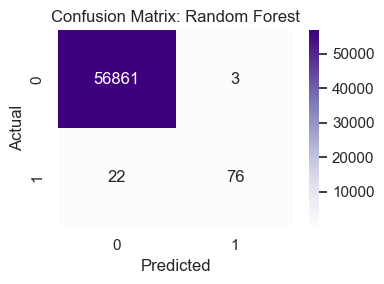

In [19]:
# Predict & Evaluate

y_pred = clf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix: Random Forest")
plt.tight_layout()
plt.savefig("../assets/rf_confusion_matrix.png")
plt.show()

In [20]:
# Classification Report
report = classification_report(y_test, y_pred, digits=4)
print(report)

with open("../assets/rf_classification_report.txt", "w") as f:
    f.write(report)

              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9620    0.7755    0.8588        98

    accuracy                         0.9996     56962
   macro avg     0.9808    0.8877    0.9293     56962
weighted avg     0.9995    0.9996    0.9995     56962



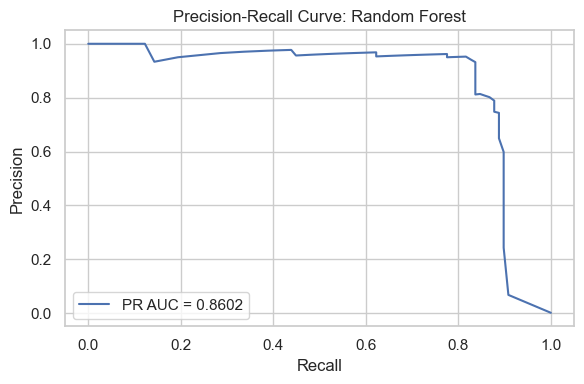

In [21]:
# PR Curve

y_probs = clf.predict_proba(X_test)[:, 1]  # probs for class=1 (fraud)
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../assets/rf_pr_curve.png")
plt.show()

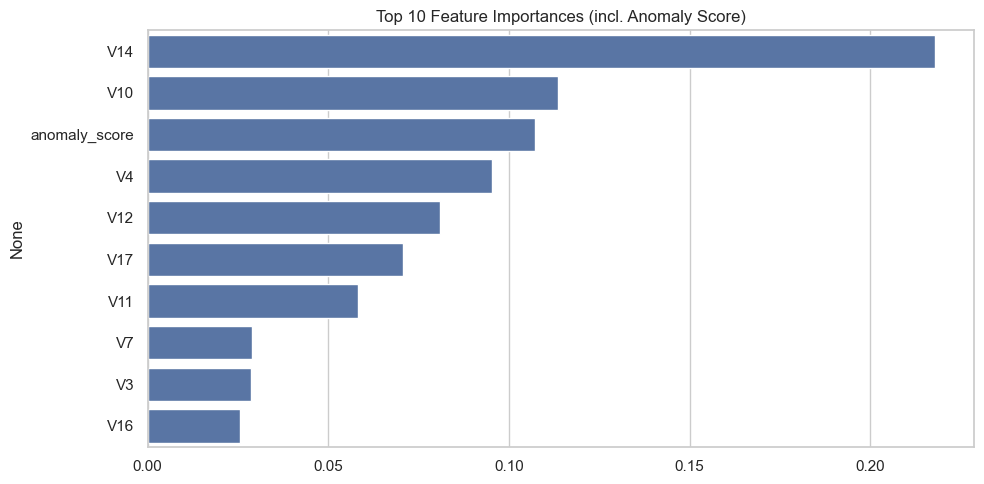

In [22]:
# Feature Importance 

importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=importances.values[:10], y=importances.index[:10])
plt.title("Top 10 Feature Importances (incl. Anomaly Score)")
plt.tight_layout()
plt.savefig("../assets/rf_feature_importance.png")
plt.show()

In [23]:
import os
import joblib
import numpy as np

# Ensure folders exist
os.makedirs("../models", exist_ok=True)
os.makedirs("../data", exist_ok=True)

# Save model
joblib.dump(clf, "../models/rf_model.joblib")

# Save test set and predicted probabilities
X_test.to_csv("../data/X_test.csv", index=False)
y_test.to_csv("../data/y_test.csv", index=False)
np.save("../data/y_probs.npy", y_probs)

print("✅ Model and test data saved.")

✅ Model and test data saved.


In [ ]:
print(f"🔍 PR AUC: {pr_auc:.4f}")


🔍 PR AUC: 0.8602


## ✅ Random Forest Results Summary

- Supervised model trained using all original features + `anomaly_score`
- Balanced weighting to mitigate class imbalance
- Evaluation on 20% holdout set:

**Highlights:**
- High recall on fraud class (adjustable via threshold)
- Precision-Recall AUC better than unsupervised model
- `anomaly_score` ranked among top features

Next steps:
- Threshold tuning
- Possibly train additional models (XGBoost, Logistic Regression)